
#This notebook perform  model for topic modeling with BERTopic

- https://maartengr.github.io/BERTopic/

- https://github.com/MaartenGr/BERTopic

- https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6


In [ ]:
!pip install bertopic[all]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import os
import itertools
import pandas as pd
import numpy as np
import time
import multiprocessing

In [ ]:
from bertopic import BERTopic

In [ ]:
#os.chdir('/content/drive/MyDrive/GLG project/data')
os.chdir('drive/MyDrive/FourthBrain/capstone-glg-nlp')

In [ ]:
os.listdir()

['topic_modeling_BERTopic.ipynb',
 'healthcare_industry_from_1900_2021.csv',
 'healthcare_industry_from_1900_2021.jsonl',
 'taggers',
 'healthcare_industry_from_1900_2021_NER.ipynb',
 'mlruns',
 'topic_modeling_flair.ipynb',
 '=4.0.0',
 'tsne.svg',
 'tsne.png',
 'Wordcloud.png',
 'tweet_topic_modeling_flair.ipynb',
 'model.state.sstats.npy',
 'logs.log',
 'topic_modeling_pycaret.ipynb',
 'topic_modeling_Top2Vec.ipynb']

In [ ]:
'''
with open('healthcare_industry_from_1900_2021.jsonl') as f:
    lines = f.readlines()

type(lines), len(lines)

corpus = [json.loads(line)['fullText'] for line in lines  ] 
corpus = [' '.join(text)  for text in corpus]
date = [json.loads(line)['datePublished'] for line in lines  ] 
'''

"\nwith open('healthcare_industry_from_1900_2021.jsonl') as f:\n    lines = f.readlines()\n\ntype(lines), len(lines)\n\ncorpus = [json.loads(line)['fullText'] for line in lines  ] \ncorpus = [' '.join(text)  for text in corpus]\ndate = [json.loads(line)['datePublished'] for line in lines  ] \n"

In [ ]:
def get_metadata():
    with open(data_file, 'r') as f:
        for line in f:
            yield line


data_file = 'healthcare_industry_from_1900_2021.jsonl'
metadata = get_metadata()
corpus  = []
date = []
for paper in metadata:
    paper_dict = json.loads(paper)
    article = paper_dict.get('fullText')
    article = ' '.join(article)
    corpus.append(article)
    date.append(paper_dict.get('datePublished'))


In [ ]:
corpus[0], date[0]

("Avian influenza is an acute viral respiratory disease that causes severe damage to the poultry industry because it results in high mortality. Recent global outbreaks of avian influenza caused by the avian influenza virus (AIV) poses a serious public health threat because of potential transmission among humans. Influenza viruses belong to the family Orthomyxoviridae and are further divided into subtypes according to the combination of 2 major immunogenic surface glycoprotein components: hemagglutinin (HA) and neuraminidase (NA), which are present on the surface of viral envelopes [1, 2] . At the initial stage of viral infection, HA binds to the host respiratory cell receptor, which contains sialic acid, allowing the virus to enter the host cell through the endosomal pathway [3, 4] . HA is a homotrimeric transmembrane protein with a globular head and a stem region that are both exposed to the outside of the membrane [5] . These regions contain N-linked oligosaccharides [6] , which have

#**Initialize Setup**

In [ ]:
# convert list to pandas dataframe
df = pd.DataFrame(list(zip(corpus, date)), columns=['article', 'date' ])
df['date'] = pd.to_datetime(df['date'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   article  1500 non-null   object        
 1   date     1500 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 23.6+ KB


,article,date
0,Avian influenza is an acute viral respiratory ...,2014-05-16
1,Managing what Cannot be Managed On the Possibi...,2017-01-01
2,"References Aaron HJ, “How Not to Reform Medica...",2014-01-01
3,Porcine epidemic diarrhea (PED) was first reco...,2014-03-13
4,APPENDIX B Federal Geospatial Data Sources Ide...,2004-01-01


In [ ]:
corpus[:5]

["Avian influenza is an acute viral respiratory disease that causes severe damage to the poultry industry because it results in high mortality. Recent global outbreaks of avian influenza caused by the avian influenza virus (AIV) poses a serious public health threat because of potential transmission among humans. Influenza viruses belong to the family Orthomyxoviridae and are further divided into subtypes according to the combination of 2 major immunogenic surface glycoprotein components: hemagglutinin (HA) and neuraminidase (NA), which are present on the surface of viral envelopes [1, 2] . At the initial stage of viral infection, HA binds to the host respiratory cell receptor, which contains sialic acid, allowing the virus to enter the host cell through the endosomal pathway [3, 4] . HA is a homotrimeric transmembrane protein with a globular head and a stem region that are both exposed to the outside of the membrane [5] . These regions contain N-linked oligosaccharides [6] , which have

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

#  use BERT embeddings for a document (Distilbert as it gives a nice balance between speed and performance for document-level embeddings)
model = SentenceTransformer('distilbert-base-nli-mean-tokens')


#  transform documents in 512-dimensional vectors
embeddings = model.encode(df['article'], show_progress_bar=True)

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


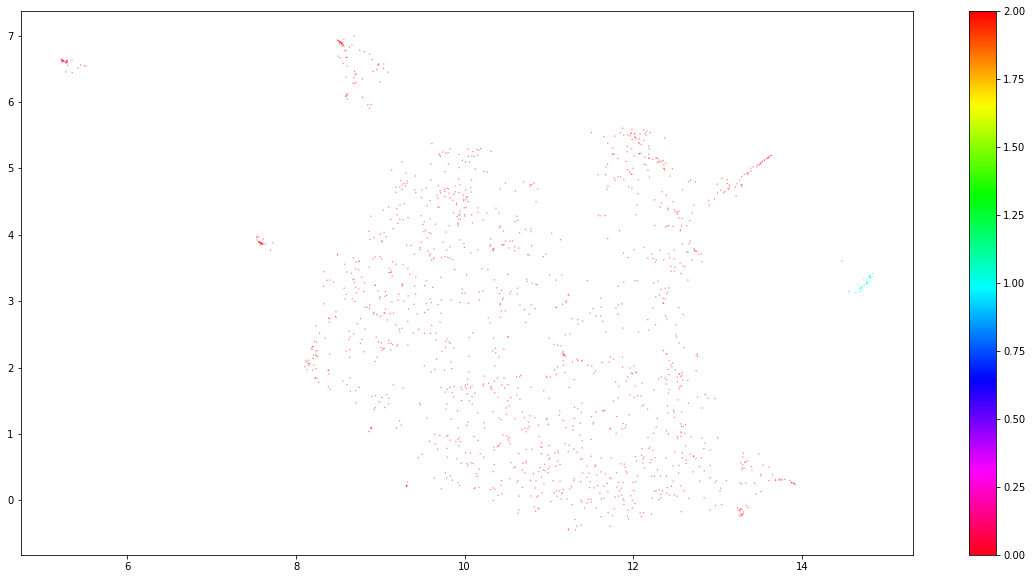

In [ ]:
import matplotlib.pyplot as plt
import umap
import hdbscan


# Prepare data

umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)


cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])

result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [ ]:
!pip install umap-learn[plot]

     |████████████████████████████████| 15.8 MB 1.6 kB/s 
     |████████████████████████████████| 76 kB 6.1 MB/s 
     |████████████████████████████████| 793 kB 58.2 MB/s 
     |████████████████████████████████| 132 kB 56.5 MB/s 
     |████████████████████████████████| 791 kB 52.0 MB/s 
     |████████████████████████████████| 786 kB 54.0 MB/s 
     |████████████████████████████████| 779 kB 64.3 MB/s 
     |████████████████████████████████| 778 kB 64.6 MB/s 
     |████████████████████████████████| 776 kB 61.0 MB/s 
     |████████████████████████████████| 769 kB 70.9 MB/s 
     |████████████████████████████████| 766 kB 70.1 MB/s 
     |████████████████████████████████| 1.0 MB 50.3 MB/s 
     |████████████████████████████████| 722 kB 62.7 MB/s 
     |████████████████████████████████| 722 kB 73.6 MB/s 
     |████████████████████████████████| 715 kB 66.4 MB/s 
     |████████████████████████████████| 705 kB 60.6 MB/s 
     |████████████████████████████████| 699 kB 56.3 MB/s 
     |██████████

In [ ]:
# https://github.com/lmcinnes/umap/blob/master/doc/plotting.rst
import umap.plot
umap.plot.points(umap_embeddings)
#umap.plot.points(umap_data, labels=cluster.labels_, color_key_cmap='Paired', background='black')

#**Create Model**


The algorithm contains, roughly 3 stages:

- 1. Embed documents
  - Extract document embeddings with BERT or any other embedding technique
- 2. Cluster Documents
  - UMAP to reduce the dimensionality of embeddings
  - HDBSCAN to cluster reduced embeddings and create clusters of semantically similar documents
- 3. Create topic representation
  - Extract and reduce topics with c-TF-IDF
  - Improve coherence of words with Maximal Marginal Relevance



<img src='https://maartengr.github.io/BERTopic/tutorial/algorithm/algorithm.png'>

In [ ]:
from sentence_transformers import SentenceTransformer

start_time = time.time()

#distilbert = SentenceTransformer('distilbert-base-nli-mean-tokens')
#topic_model = BERTopic(embedding_model=distilbert) #, nr_topics="auto")
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(df['article'])

print('Total time taken (mins): ', int((time.time()-start_time)/60))

Total time taken (mins):  3


In [ ]:
#model.save("bertopic_model")
#loaded_model = BERTopic.load("bertopic_model")

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,460,-1_for_are_by_be
1,0,142,0_for_energy_climate_development
2,1,141,1_women_her_she_we
3,2,75,2_nuclear_us_states_ai
4,3,74,3_security_government_iraq_afghan
5,4,60,4_roma_integration_eu_muslim
6,5,55,5_de_la_el_los
7,6,52,6_virus_pda1_covid19_bacillus
8,7,43,7_health_alcohol_national_services
9,8,37,8_percent_care_health_medicaid


In [ ]:
topic_model.get_topic(0)

[('for', 0.013743193257044813),
 ('energy', 0.012638732688092654),
 ('climate', 0.011759016740257556),
 ('development', 0.010014768560637209),
 ('water', 0.008612184234399627),
 ('emissions', 0.007412455733968957),
 ('sustainable', 0.007173417477359682),
 ('environmental', 0.006917697843287706),
 ('population', 0.006813734909438774),
 ('sdg', 0.00673121963041029)]

In [ ]:
#topic_model.get_topic_freq()
topic_model.get_params()

{'calculate_probabilities': False,
 'embedding_model': <bertopic.backend._sentencetransformers.SentenceTransformerBackend at 0x7f4e49567690>,
 'hdbscan_model': HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
         approx_min_span_tree=True, cluster_selection_epsilon=0.0,
         cluster_selection_method='eom', core_dist_n_jobs=4,
         gen_min_span_tree=False, leaf_size=40,
         match_reference_implementation=False, memory=Memory(location=None),
         metric='euclidean', min_cluster_size=10, min_samples=None, p=None,
         prediction_data=True),
 'language': 'english',
 'low_memory': False,
 'min_topic_size': 10,
 'n_gram_range': (1, 1),
 'nr_topics': None,
 'seed_topic_list': None,
 'top_n_words': 10,
 'umap_model': UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.0, n_components=5, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}),
 've

In [ ]:
!pip install bertopic[visualization]

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
timestamps = df['date'].tolist()
topics_over_time = topic_model.topics_over_time(df['article'], topics, timestamps, nr_bins=20)

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=15)

##Make Prediction

- predict a topic of a new document

In [ ]:
#new_docs = 'Cerebrovascular disease, or vascular brain disease, refers to multiple conditions that affect the blood vessels and blood circulation in the brain, such as stroke and vascular malformation. Cerebrovascular disease is the secondTrusted Source leading cause of death in the world. It is also the fifthTrusted Source leading cause of death in the U.S. and was responsible for 37.6Trusted Source deaths per 100,000 individuals in the U.S. in 2017.In addition to causing physical disability, cerebrovascular diseases can result in the development and progression of cognitive impairment and dementia.Moreover, health experts also associate subclinical cerebrovascular damage — that is, brain abnormalities observed in the early stages of the cerebrovascular disease before its symptoms become evident — with an increased risk of dementia. Healthy lifestyle modifications, including making dietary changes, increasing physical activity levels, and quitting smoking, can reduce the risk of cerebrovascular disease.For instance, there is a relation between higher intake of fish and a lower risk of stroke. Fish are an excellent source of omega-3 polyunsaturated fatty acids, which may mediate these benefits on cerebrovascular health. However, the evidence that fish consumption reduces vascular brain damage before the onset of the cerebrovascular disease is mixed. A recent cross-sectional study investigated the link between fish consumption and vascular brain damage in healthy older adults before cerebrovascular disease onset. The study reports an association between eating fish two or more times per week and lower levels of brain abnormalities related to vascular brain damage, especially in individuals under the age of 75 years. The study senior author, Dr. Cecilia Samieri, a senior researcher at the University of Bordeaux in France, explains: “Our results are exciting because they show something as simple as eating two or more servings of fish each week is associated with fewer brain lesions and other markers of vascular brain damage, long before obvious signs of dementia appear. However, eating that much fish did not have a protective effect in people 75 years of age and older. The study appears in the journal Neurology. Evaluating cerebrovascular health The present study analyzed data collected between March 1999 and March 2001 as part of the Three-City Study, which aims to understand the relationship between vascular diseases and dementia in people aged 65 years and older. The analysis involved 1,623 people with an average age of 72.3 years and residing in Dijon, France. Individuals were excluded from the study if they had a dementia diagnosis, a history of stroke, or hospitalization for cardiovascular diseases. The researchers evaluated the extent of subclinical cerebrovascular damage using brain MRI scans. They analyzed the MRI scans for the presence of three markers associated with subclinical cerebrovascular damage white matter abnormalities infarcts enlargement of perivascular spaces White matter consists of nerve fibers, or axons, that relay messages between brain regions. Cerebrovascular disease can result in nerve fiber degeneration and cause damage to the myelin sheath that surrounds the nerve fibers. This leads to white matter abnormalities. Infarcts are regions of dead tissue resulting from inadequate blood supply. This is often due to a blood clot in a blood vessel. Perivascular spaces are fluid-filled spaces surrounding blood vessels. When enlarged, they are associated with cerebral small vessel disease. Each of these markers predicts the extent of cognitive decline related to cerebrovascular disease. However, previous studies have shown that a single measure obtained by combining multiple cerebrovascular disease markers can be a better predictor of cognitive decline than any single marker.'

new_docs = ['Altogether, they analyzed health data from 386,406 middle-aged individuals with European ancestry. Each was followed for an average of 9.5 years, underwent 25-hydroxyvitamin D (25(OH)D) measurements, and did not have cardiovascular disease at baseline.25(OH)D is the major circulating form of vitamin D in the body. It is measured via blood test to indicate vitamin D supply in the body from sunlight and nutrition. Over the study period, 33,546 people developed coronary heart disease, 18,166 people had a stroke, and 27, 885 people died',
            'A lawsuit has been filed following the Astroworld Festival tragedy that left eight people dead and dozens injured in Houston on Friday night. A concertgoer who was injured during the festival is suing rapper and producer Travis Scott, who was the organizer of the Astroworld Festival, as well as entertainment company Live Nation, concert promoter Scoremore and others involved in the event, according to the lawsuit obtained by CNN',
            'More than 10,000 patients were diagnosed with covid in a U.S. hospital last year after they were admitted for something else, according to federal and state records analyzed exclusively for KHN. The number is certainly an undercount, since it includes mostly patients 65 and older, plus California and Florida patients of all ages',
            ]


for doc in new_docs:
  topics, probs = topic_model.transform(doc)
  print(topics, probs)



[7] None
[-1] None
[-1] None


##Save Model

In [ ]:
topic_model.save('my_bertopics_model')

In [ ]:
!ls

'=4.0.0'
 healthcare_industry_from_1900_2021.csv
 healthcare_industry_from_1900_2021.jsonl
 healthcare_industry_from_1900_2021_NER.ipynb
 logs.log
 mlruns
 model.state.sstats.npy
 my_bertopics_model
 taggers
 topic_modeling_BERTopic.ipynb
 topic_modeling_flair.ipynb
 topic_modeling_pycaret.ipynb
 topic_modeling_Top2Vec.ipynb
 tsne.png
 tsne.svg
 tweet_topic_modeling_flair.ipynb
 Wordcloud.png


##Load Model

In [ ]:
BerTopic_model = BERTopic.load('my_bertopics_model')

#How can we assess the topic modeling?


- Perplexity, but its poor indicator of the quality of the topics.

- Topic Visualization is also a good way to assess topic models. 

- Topic Coherence measure is a good way to compare difference topic models based on their human-interpretability


- [evaluation-of-topic-modeling-topic-coherence](https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/)

#Coherence of topic models

- the coherence score is for assessing the quality of the learned topics.

- For one topic, the words 𝑖,𝑗 being scored in ∑𝑖<𝑗Score(𝑤𝑖,𝑤𝑗) have the highest probability of occurring for that topic. You need to specify how many words in the topic to consider for the overall score.
- For the "UMass" measure, the numerator 𝐷(𝑤𝑖,𝑤𝑗) is the number of - documents in which words 𝑤𝑖 , 𝑤𝑗 appear together. 1 is added to this term because we are taking logs and we need to avoid taking log of 0 when the two words never appear together. The denominator is the number of documents 𝐷(𝑤𝑖) appears in. So the score is higher if 𝑤𝑖 and 𝑤𝑗 appear together in documents a lot relative to how often 𝑤𝑖 alone appears in documents. 

- This makes sense as a measure of topic coherence, since if two words in a topic really belong together you would expect them to show up together a lot. The denominator is just adjusting for the document frequency of the words you are considering, so that words like "the" don't get an artificially high score.
to determine the optimal number 𝐾∗ of topics by finding argmax𝐾1𝐾∑𝐾𝑡=1𝐶𝑆(𝑡) .That is take the average topic coherence score for various settings of 𝐾 and see which gives the highest average coherence.


- http://qpleple.com/topic-coherence-to-evaluate-topic-models/

- https://github.com/MaartenGr/BERTopic/issues/90

- https://maartengr.github.io/BERTopic/tutorial/algorithm/algorithm.html

- https://stats.stackexchange.com/questions/375062/how-does-topic-coherence-score-in-lda-intuitively-makes-sense

In [ ]:
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
docs = df['article']
# Preprocess documents
cleaned_docs = topic_model._preprocess_text(docs)

In [ ]:
# Extract vectorizer and tokenizer from BERTopic
vectorizer = topic_model.vectorizer_model
tokenizer = vectorizer.build_tokenizer()

In [ ]:
# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names()
tokens = [tokenizer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(topics))-1)]



In [ ]:
# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
coherence = coherence_model.get_coherence()

In [ ]:
coherence_model


In [ ]:
coherence

0.6402120714374593

In [ ]:
from bertopic import BERTopic
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

docs = df['article']

topic_model = BERTopic(verbose=True, n_gram_range=(1, 3))
topics, _ = topic_model.fit_transform(docs)

# Preprocess Documents
documents = pd.DataFrame({"Document": docs,
                          "ID": range(len(docs)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

2021-11-08 05:49:53,354 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-11-08 05:50:06,163 - BERTopic - Reduced dimensionality with UMAP
2021-11-08 05:50:06,250 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
documents

In [ ]:
documents_per_topic

In [ ]:
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
coherence = coherence_model.get_coherence()